# Analyzing NYC High School Data

## Introduction and purpose


The ["SAT" (Scholastic Aptitude Test)](https://en.wikipedia.org/wiki/SAT) is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it. The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points.Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

There is controversy around this test (and other standardized tests) though: are they unfair to certain groups?

In this study we will investigate correlations between SAT scores and demographics like race, gender, income, and more.


### Data

We will make us of data that is published by the City of New York. This includes SAT scores, demographic information and other data that is useful for our study. Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt):  attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j): Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8): Surveys of parents, teachers, and students at each school


### Contents

The remainder of the notebook contains the following sections:

* Data preparations and cleaning
* Overview of the data
* Data analysis and visualization
* SAT scores per boro and per district
* Wrap-up and conclusions

## Data preparations and cleaning

In this section, we will first read in all the data, and do necessary data cleaning. Since all datasets are interrelated, we will combine them into a single dataset, that we can next use to find correlations.

 *Note: the code that follows next in this section is courtesy [Dataquest](https://www.dataquest.io/). That is, during 'guided excercises' I actually did write the code to perform all the steps done below, but for convenience, for this notebook I have here reused code that was provided by Dataquest rather than copying all of my own code snippets. Some minor changes were made.*
 
 *Further down there will be another marker to indicate till where this applies. After that marker, all code was written by me.*

### Read in the data

In [58]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [59]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort = True) #JQ, added sort = True to silence a warning

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [60]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [61]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [62]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [63]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [64]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [65]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations

In [66]:
correlations = combined.corr()
correlations = correlations["sat_score"]
# print(correlations)

*Marker: end of code courtesy Dataquest. All code that follows was written by myself.*



## Overview of the data

Before we continue with analysis and visualization, let's first take a look at the `combined` dataframe and the correlation table that we have created in the previous step.

In [67]:
#Check the size of our dataframe
print ('Nr of columns: ', combined.shape[1])
print ('Nr of rows: ', combined.shape[0])

Nr of columns:  160
Nr of rows:  363


So we have data for 363 schools, and not less than 161 pieces of info for each of them. Let's take a look at a sample.

In [68]:
# Show a sample of the data, for all columns in our dataframe
pd.set_option("display.max_columns", None)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,153.45,Total Cohort,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78.0,43,55.1%,36,46.2%,83.7%,0,0%,0%,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%,1,88.000000,4.000000,22.564286,18.500000,26.571429,0.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,0,88.6,422,,,,,,,,32,33,50,98,79,80,50,94.0,22.3,105.0,24.9,34,35,59,14.0,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,6.3,5.3,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0,01M292,Henry Street School for International Studies,Manhattan,M056,212-406-9411,212-406-9417,6,12,0,12.0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,0,0,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Chinese Language and Culture, Spanish Literatu...","Chinese (Mandarin), Spanish","Math through Card Play; Art, Poetry/Spoken Wor...",Basketball,Softball,Soccer,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,0,0,United Nations,0,0,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M

In addition we have a table `correlations` that contains the correlations between the overall SAT score (`sat_score`) and all other columns. Let's print that one in full.

In [69]:
# Sample of the correlations between SAT score and other data
pd.options.display.max_rows = 200
print (correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Data analysis and visualization

In this section, we will do analysis on the combined dataset and the correlations, mainly by visualization in a variety of charts. We will take a look at the correlation of SAT scores with:
* survey results
* safety
* racial factors
* gender
* AP scores

In [70]:
# Import matplotlib library and enable inline plotting 
import matplotlib.pyplot as plt
%matplotlib inline

### Correlation of SAT scores with survey results

Some of the fields in our dataset originate from a survey of parents, teachers and students. Let's see how these correlate with the SAT score.

In [71]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation. (Okay, this one line is still from Dataquest.).
survey_fields.remove("DBN")

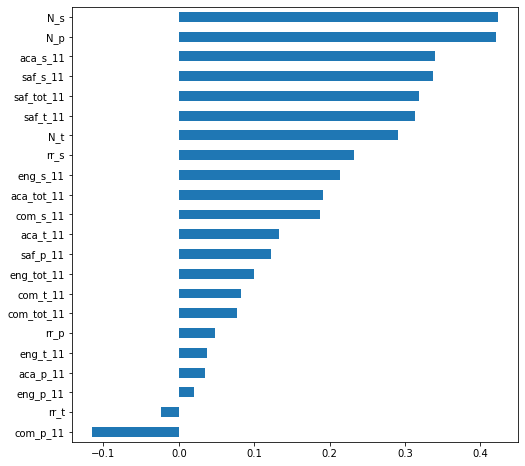

In [72]:
# Visualize the correlation of survey fields with SAT score
correlations[survey_fields].sort_values().plot(kind  = 'barh', figsize = (8,8), sort_columns = True)
plt.show()

The [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) on the City of New York's website gives the following meaning for these fields (where it seems a safe assumption that `aca_tot_10` and `aca_tot_11` or `eng_s_10` and `end_s_11` have the same meaning, only refer to a different year.):

<img src='survey_fields_pic.PNG' width="500" height="500" align ='left'>



 

The highest correlation can be seen for `N_s` and `N_p`, the number of students and parents that responded. In the correlation table further above, we could also see there was a positive correlation between SAT score and total enrollment. So that's basically the same observation again. If we look at response *rates*, then we can actually still see a positive correlation. <br><br>
Next highest is `aca_s_11`. So where students have high expectations, they score well on the SAT tests. Not truly surprising: these are likely skilled and motivated students.<br><br>
The next three all relate to safety and respect scores. So in schools that are perceived as safe and respectful (by teachers and students in particular), SAT scores soar.

### Correlation of SAT scores with safety

We just saw there is a positive correlation between (perceived) safety and respect and SAT scores. Let's explore this further.

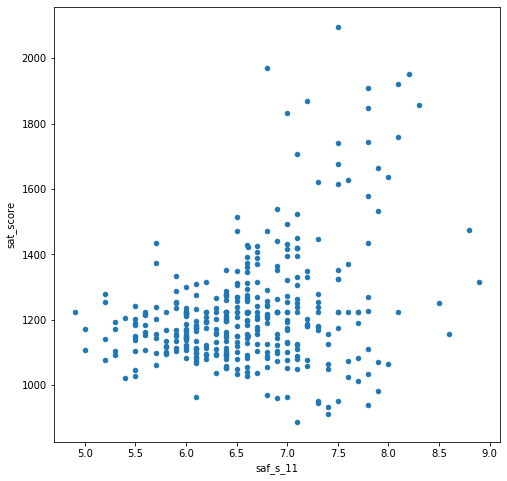

In [73]:
# Scatter plot of safety score (students)vs SAT scores
combined.plot(kind='scatter', x='saf_s_11', y='sat_score', figsize = (8,8))
plt.show()

So the scatter plot indeed shows a positive correlation. However it is not *that* strong. (Actually the 4 schools with the highest safety scores are quite average in terms of SAT scores).

Let's take a look at the perceived safety score per borough.

In [74]:
# Calculate the average of saf_s_11 per borough
safety_per_borough = combined.loc[:,['boro','saf_s_11', 'sat_score']]
safety_per_borough = safety_per_borough.groupby('boro', as_index = False).agg(numpy.mean)
safety_per_borough

,boro,saf_s_11,sat_score
0,Bronx,6.606577,1157.598203
1,Brooklyn,6.370755,1181.364461
2,Manhattan,6.831370,1278.331410
3,Queens,6.721875,1286.753032
4,Staten Island,6.530000,1382.500000


It looks like Manhattan and Queens are perceived safest, and Brooklyn least safe.
Let's also see whether at this aggregated level we can see a clear correlation between perceived safety and SAT score

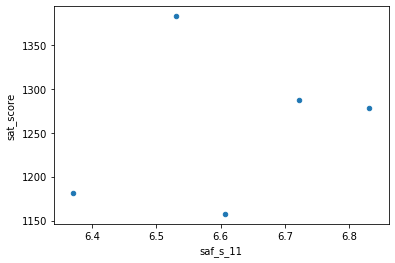

In [75]:
# Scatter plot SAT score vs safety score
safety_per_borough.plot(kind = 'scatter', x = 'saf_s_11', y = 'sat_score')
plt.show()

That's not very convincing: at aggregated boro level, no clear correlation between perceived safety and SAT score.

### Correlation of SAT scores with racial factors

Our dataset contains fields with the percentages of white, Asian, black and Hispanic students. Let's explore correlations between these and the SAT score.

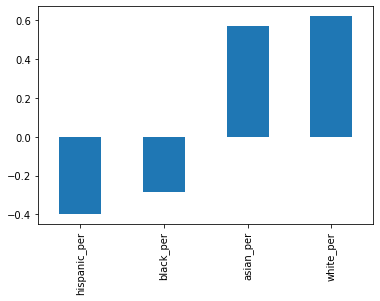

In [76]:
# Create a bar chart that shows the correlation between SAT score and race fields 
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per'] 
correlations[race_fields].sort_values().plot(kind  = 'bar', sort_columns = True)
plt.show()

So there seems to be a fairly strong correlation. Schools with higher percentages of Asian and/or white students appear to have higher SAT scores, while schools with higher percentages of Hispanic and/or black students tend to have lower SAT scores. <br> <br>
This is a potentially sensitive topic, however let's explore further.
Given what we see in the graph for Hispanic, let's zoom in further.

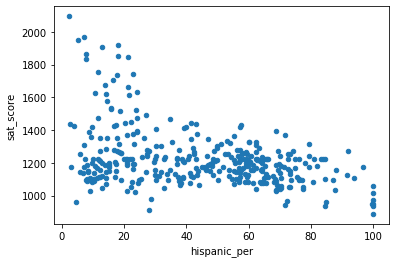

In [77]:
# Scatter plot SAT scores vs hispanic percentage
combined.plot(kind = 'scatter', x = 'hispanic_per', y = 'sat_score')
plt.show()

This plot seems to confirm the strong correlation: schools with higher percentages of Hispanic students tend to score lower SAT scores. At the far end of the graph, we see several schools with a percentage of (close to) 100%, with SAT scores of around 1000 and below. Let's explore those further.

In [78]:
# Select schools with an hispanic percentage over 95%, and show some data
schools_with_high_hisp_perc = combined[combined.hispanic_per >95]
schools_with_high_hisp_perc[['SCHOOL NAME','boro', 'hispanic_per', 'sat_score']].sort_values('sat_score', ascending = True)

,SCHOOL NAME,boro,hispanic_per,sat_score
253,MULTICULTURAL HIGH SCHOOL,Brooklyn,99.8,887.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,Bronx,99.8,934.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,Bronx,99.4,951.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,Queens,100.0,951.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,Bronx,99.8,970.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,Manhattan,99.8,1014.0
44,MANHATTAN BRIDGES HIGH SCHOOL,Manhattan,99.8,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,Manhattan,96.7,1174.0


A bit of research on these schools on the web indicates that these schools specifically target Spanish-speaking students, e.g. recent immigrants. A lower proficiency in English may lead to lower SAT scores.

Let's also take a look at the other end of the spectrum: schools with a low percentage of Hispanic students and high SAT scores.

In [79]:
# Select schools with an hispanic percentage below 10% and a SAT score above 1800, and show some data
schools_with_low_hisp_perc = combined[(combined.hispanic_per < 10) & (combined.sat_score > 1800)]
schools_with_low_hisp_perc[['SCHOOL NAME','boro', 'hispanic_per', 'sat_score']].sort_values('sat_score', ascending = False)

,SCHOOL NAME,boro,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,Manhattan,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,Bronx,7.2,1969.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,Staten Island,5.3,1953.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,Queens,7.9,1868.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,Brooklyn,7.9,1833.0


Many of these schools seem to focus on science and technology. When looking them up on the web, you can find that many of them have admission tests. So the high SAT scores at the end of school can possibly partially be explained by selection of students already prior to entering the school in the first place. This does not explain the low percentages of Hispanics; 'proficiency in English' will play a role in being able to score on admission tests as well, and (at least for some) is even explicitly part of the admission tests. 

### Correlation of SAT scores with gender

Our dataset contains fields with the percentages of male and female students. Let's explore correlations between these and the SAT score.


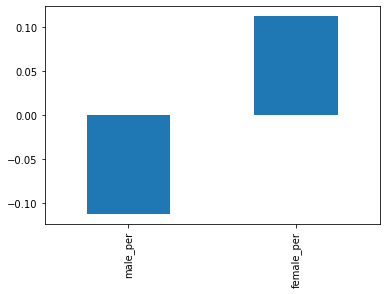

In [80]:
# Create a bar chart that shows the correlation between SAT score and gender fields 
gender_fields = ['male_per', 'female_per'] 
correlations[gender_fields].sort_values().plot(kind  = 'bar')
plt.show()

So a higher percentages of female students seems to correlate with higher SAT scores, and a higher percentage of male students correlates with lower SAT scores. Let's explore further.

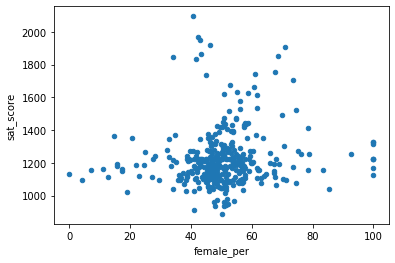

In [81]:
# Scatter plot SAT scores vs females percentage
combined.plot(kind = 'scatter', x = 'female_per', y = 'sat_score')
plt.show()

So actually the correlation between percentage of female students and SAT score doesn't seem to be that strong. The highest SAT scores are in schools with more mixed (male/female) populations, and the schools with the very highest percentages of female students do not score really high SAT-wise.
Let's take a further look though, and zoom in on the cluster of schools with relatively high percentages of female students *and* high SAT scores.

In [82]:
# Select schools with an female percentage over 60% and a SAT score above 1700, and show some data
schools_with_high_female_perc = combined[(combined.female_per > 60) & (combined.sat_score > 1700)]
schools_with_high_female_perc[['SCHOOL NAME','boro', 'female_per', 'white_per', 'asian_per', 'black_per', 'hispanic_per','sat_score']].sort_values('sat_score', ascending = False)

,SCHOOL NAME,boro,female_per,white_per,asian_per,black_per,hispanic_per,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,Queens,71.1,24.6,55.5,5.9,12.9,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,Manhattan,68.7,49.8,15.1,15.1,18.2,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,Manhattan,67.5,63.7,17.2,5.5,11.6,1758.0
60,BEACON HIGH SCHOOL,Manhattan,61.0,49.8,8.9,14.6,22.8,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,Manhattan,73.6,49.2,19.6,12.9,16.6,1707.0


A brief look on the web for these schools seems to indicate that are just schools with high academic standards, and admission tests. What's interesting to see in the table above is that at least for these schools, the numbers of racial background vary significantly. 

### Correlation of SAT scores with AP scores

In the U.S., high school students take [Advanced Placement (AP) exams](https://en.wikipedia.org/wiki/Advanced_Placement_exams) to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [83]:
# Add new column with the percentage of students that took an AP exam ()
combined['ap_per'] = combined['AP Test Takers ']/ combined['total_enrollment']

# To check the result, then comment out:
# combined[['ap_per', 'AP Test Takers ', 'total_enrollment']].head(10)

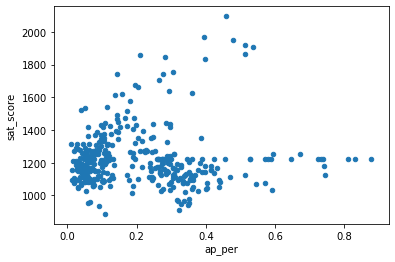

In [84]:
# Scatter plot percentage of AP Test percentage against SAT score
combined.plot(kind = 'scatter', x = 'ap_per', y = 'sat_score')
plt.show()

Not a very strong relationship. Higher percentages of students that take AP exams somewhat go hand-in-hand with higher SAT scores, but it does not look like a strong correlation.

*Note: the analyses and visualizations above of various correlations where created as suggested by Dataquest. What followswas added at own initiative.*

## SAT scores per boro and per district

In our `combined` dataset we have, as we saw, data of 363 schools. Each school belongs to a school district, and each school district is in one of the 5 boros that make up New York. In this section we are going to explore till what extent the SAT score vary over these boros, and also over the districts within these boros. 

### Prepare the data

Create aggregations, with average SAT scores at boro level and at district level.

In [85]:
# Check which districts exist
combined['school_dist'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

So we have 5 boros, that contains 32 districts and 363 schools.

In [86]:
# For convenience, create a dataframe that only contains the columns that we need
combined_less_columns = combined.loc[:,['boro','school_dist', 'sat_score', 'DBN']]
# combined_less_columns # Commented out after checking the result is correct.)

In [87]:
# Create a dataframe that aggregates the data per boro and per district. Average the SAT score, and count the number of schools.
data_per_district_aggregated = combined_less_columns.groupby(['boro','school_dist'], as_index = False).agg({'sat_score': numpy.mean, 'DBN': 'count'})
data_per_district_aggregated.rename(columns = {'DBN': 'school_count'}, inplace = True)
data_per_district_aggregated


,boro,school_dist,sat_score,school_count
0,Bronx,07,1128.846154,13
1,Bronx,08,1159.665129,11
2,Bronx,09,1131.971940,20
3,Bronx,10,1222.227273,22
4,Bronx,11,1165.000000,15
5,Bronx,12,1101.823134,12
6,Brooklyn,13,1237.187600,13
7,Brooklyn,14,1179.459915,14
8,Brooklyn,15,1190.604312,9
9,Brooklyn,16,1120.109701,4


In [88]:
# Check correctness: is the number of schools still 363? 
print ('School count: ', data_per_district_aggregated['school_count'].sum())


School count:  363


In [89]:
# Further aggregate per boro. And count the number of districts and the number of schools per boro.
data_per_boro_aggregated = data_per_district_aggregated.groupby('boro',as_index = False).agg({'sat_score': numpy.mean, 'school_dist': 'count', 'school_count': 'sum'})
data_per_boro_aggregated.rename(columns = {'sat_score' : 'flawed_sat_score', 'school_dist': 'district_count'}, inplace = True)
data_per_boro_aggregated

,boro,flawed_sat_score,district_count,school_count
0,Bronx,1151.588938,6,93
1,Brooklyn,1193.163096,12,106
2,Manhattan,1269.571774,6,90
3,Queens,1293.865555,7,64
4,Staten Island,1382.500000,1,10


In [90]:
# Check whether the total number of districts and schools is still correct:
print ('District count', data_per_boro_aggregated['district_count'].sum())
print ('School count: ', data_per_boro_aggregated['school_count'].sum())


District count 32
School count:  363


The average SAT Score per boro is incorrect though above. This is, for every boro, the average of the "average SAT score per district", so if not every district contains the same number of schools this would be incorrect. Let's calculate the correct value and replace. 

In [91]:
# Calculate average SAT score per boro
sat_score_per_boro = combined_less_columns.groupby('boro',as_index = False).agg({'sat_score': numpy.mean})
sat_score_per_boro

,boro,sat_score
0,Bronx,1157.598203
1,Brooklyn,1181.364461
2,Manhattan,1278.331410
3,Queens,1286.753032
4,Staten Island,1382.500000


In [92]:
data_per_boro_aggregated['sat_score'] = sat_score_per_boro['sat_score']
data_per_boro_aggregated.drop(['flawed_sat_score'], axis = 1, inplace = True)
data_per_boro_aggregated


,boro,district_count,school_count,sat_score
0,Bronx,6,93,1157.598203
1,Brooklyn,12,106,1181.364461
2,Manhattan,6,90,1278.331410
3,Queens,7,64,1286.753032
4,Staten Island,1,10,1382.500000


### Visualize the data

Let's create bar charts with the average SAT score per boro and per district

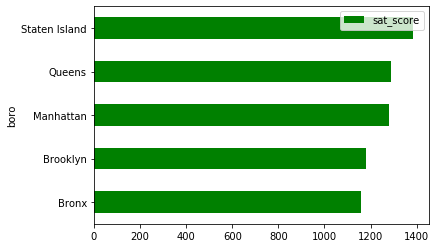

In [93]:
# Visualize per boro
data_per_boro_aggregated[['boro', 'sat_score']].plot(kind = 'barh', x = 'boro', color = 'green')
plt.show()

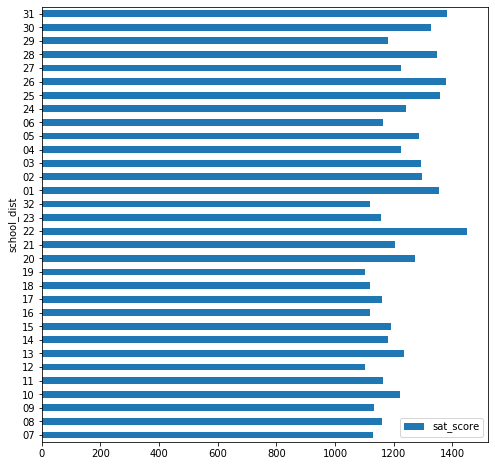

In [94]:
# Visualize per boro
data_per_district_aggregated[['school_dist', 'sat_score']].plot(kind = 'barh', x = 'school_dist', figsize = (8,8))
plt.show()

We can improve these visualizations by adding colors and improving the sorting.

In [95]:
# Give each boro a color.
color_dictionary = {'Bronx': 'red', 'Staten Island': 'blue', 'Manhattan': 'green', 'Queens': 'pink', 'Brooklyn': 'orange'}
# To test, after succes comment out
# shouldbeorange = color_dictionary.get('Brooklyn')
# shouldbeorange

In [96]:
# For convenience, simplify names
dpb = data_per_boro_aggregated
dpd = data_per_district_aggregated

In [97]:
# Sort the dataframe so we can get a sorted bar chart
dpb.sort_values(by = 'sat_score', ascending = True, inplace = True)

In [98]:
# Create a function that returns the color of a boro
def getcolor (boro):
    return color_dictionary.get(boro)

In [99]:
# Create a list of colors (in the correct sequence) to be used in the chart per boro
mydpbcolorlist = []

for an_entry in dpb['boro']:
    mycolor = getcolor (an_entry)
    mydpbcolorlist.append(mycolor)
print (mydpbcolorlist)

['red', 'orange', 'green', 'pink', 'blue']


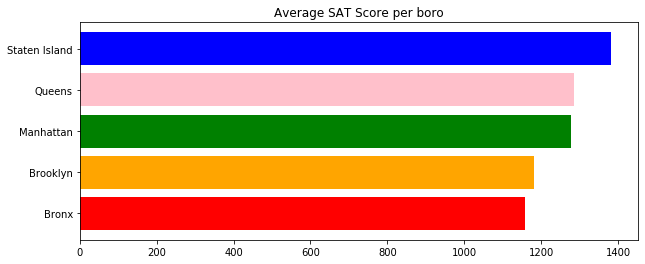

In [100]:
# Create a bar chart per boro (applying the colors)
fig, ax = plt.subplots(figsize = (10,4))
plt.barh (dpb['boro'], dpb['sat_score'], color = mydpbcolorlist)
plt.title('Average SAT Score per boro')
plt.show()

What we can see from the chart is that there are significant differences between the boros. This is of course not entirely unexpected, as likely the demographic factors that we explored earlier are different for the boro.

Now let's create a bar chart per district as well, using the same color coding.

In [101]:
# Sort the dataframe so we can get a sorted bar chart
dpd.sort_values(by = 'sat_score', ascending = True, inplace = True)

In [102]:
# Create color list for the chart
mydpdcolorlist = []

for an_entry in dpd['boro']:
    mycolor = getcolor (an_entry)
    mydpdcolorlist.append(mycolor)
# print (mydpdcolorlist) # Comment out after checking

In [103]:
# Create legend for the chart
mylabels = list(color_dictionary.keys())
myhandles = [plt.Rectangle((0,0),1,1, color=color_dictionary[label]) for label in mylabels]

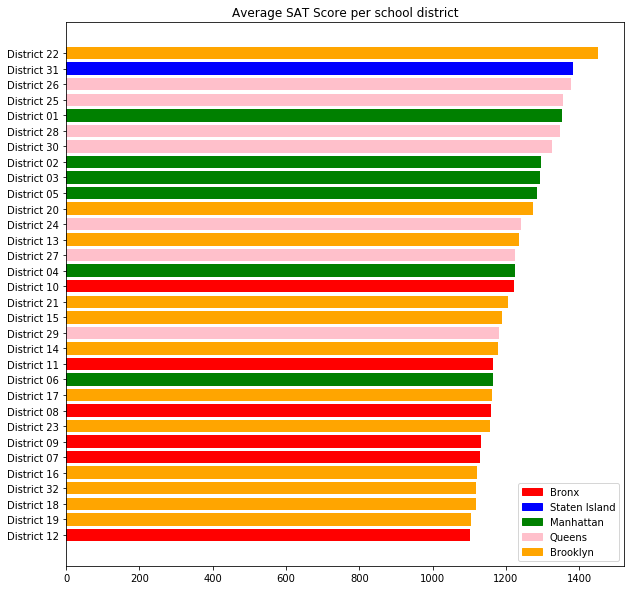

In [104]:
# Create a bar chart per district(applying the colors)
fig, ax = plt.subplots(figsize = (10,10))
plt.barh ('District '+ dpd['school_dist'], dpd['sat_score'], color = mydpdcolorlist )
plt.title('Average SAT Score per school district')
plt.legend(myhandles, mylabels, loc = 4)
plt.show()

What we can see from this chart, is that within each boro there are still significant differences between the districts. In Queens though, almost all districts are in the top half of the chart though, while for Bronx almost all districts are at the bottom of the chart. Brooklyn contains the highest scoring district, but also many districts in the lower ranges of the chart.

Next, it could be interesting to make the same chart for all 363 schools (with the same color coding), but let's keep that for a next occasion.

## Wrap-up and conclusions

In this study we have combined a lot of (publicly available) data of NYC schools, and explored the correlation between SAT scores and multiple factors. Observations included that:
* SAT scores tend to be higher at schools with a higher (perceived) safety 
* SAT scores tend to be higher at schools with high percentages of white and Asian students, and lower at schools with high percentages of Hispanic and black students
* SAT scores tend to be higher at schools with above average percentages of female students

Also we saw that the average SAT scores differ significantly over the 5 boro's of New York, and then within these boro's there are still significant differences per school district.